<a href="https://colab.research.google.com/github/Smita1908/Handwritten-digit-recognition/blob/main/Image_classification_with_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

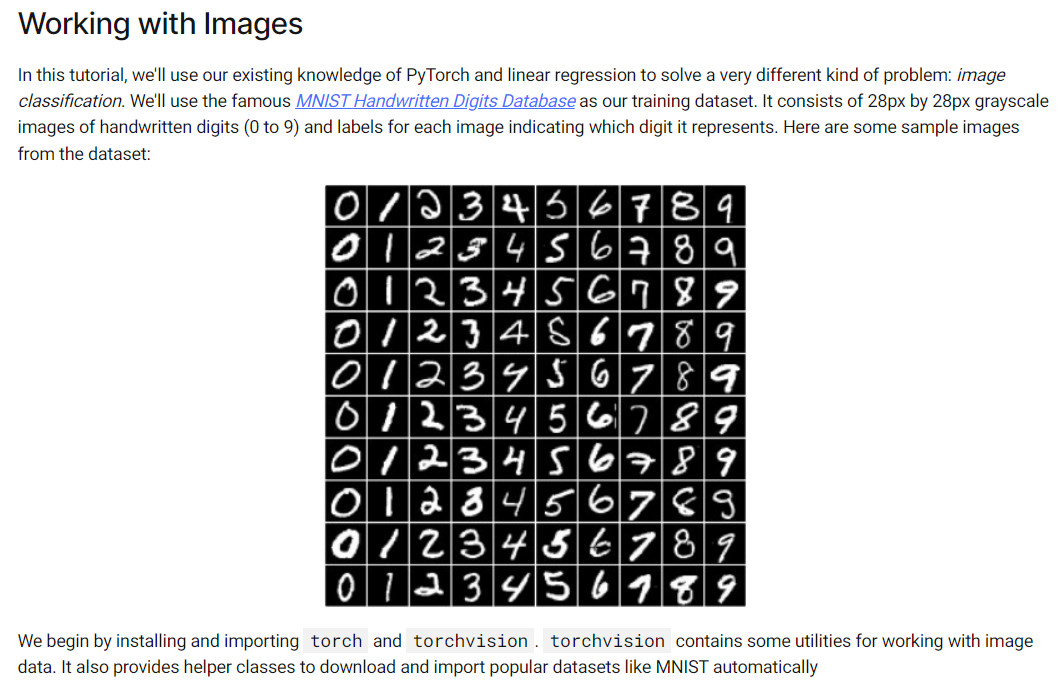

Exploring the data

We begin by importing `torch` and `torchvision`.   `torchvision` contains some utilities for working with image data. It also contains helper classes to automatically download and import popular datasets like `MNIST`.

In [ ]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [ ]:
# Download training dataset
dataset = MNIST(root = 'data/', download = True)

100%|██████████| 9912422/9912422 [00:00<00:00, 135561772.87it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 45954360.33it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 127132693.55it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 9292940.86it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



When this statement is executed for the first time, it downloads the data to the `data/` directory next to the notebook and creates a PyTorch `Dataset`. On subsequent executions, the download is skipped as the data is already downloaded. Let's check the size of the dataset.

In [ ]:
len(dataset)

60000

The dataset has 60,000 images which can be used to train the model. There is also an additional test set of 10.000 images which can be created by passing train = False to the MNIST class.

In [ ]:
test_dataset = MNIST(root = 'data/', train = False)
len(test_dataset)

10000

Let's look at a sample element from the training dataset.

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

It's a pair, consisting of a 28x28px image and a label. The image is an object of the class `PIL.Image.Image`, which is a part of the Python imaging library [Pillow](https://pillow.readthedocs.io/en/stable/). We can view the image within Jupyter using [`matplotlib`](https://matplotlib.org/), the de-facto plotting and graphing library for data science in Python.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

The statement `%matplotlib inline` indicates to Jupyter that we want to plot the graphs within the notebook. Without this line, Jupyter will show the image in a popup. Statements starting with `%` are called magic commands and are used to configure the behavior of Jupyter itself. You can find a full list of magic commands here: https://ipython.readthedocs.io/en/stable/interactive/magics.html .

Let's look at a couple of images from the dataset.

Label: 5


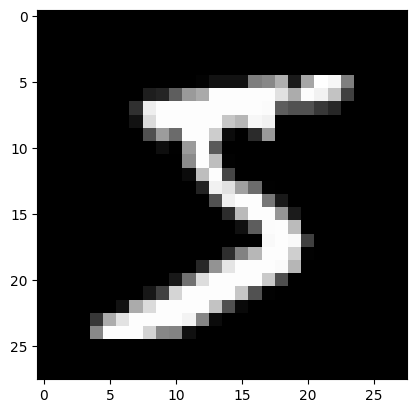

In [ ]:
image, label = dataset[0]
plt.imshow(image, cmap = 'gray')
print('Label:' , label)

Label: 3


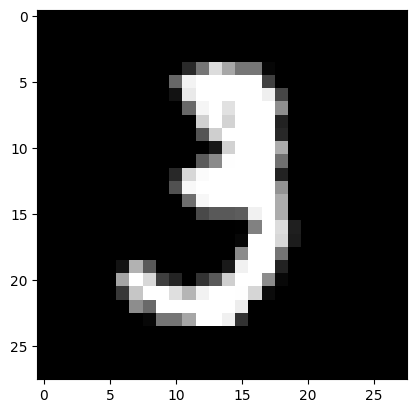

In [ ]:
image, label = dataset[10]
plt.imshow(image, cmap = 'gray')
print('Label:' , label)

It's evident that these images are relatively small in size, and recognizing the digits can sometimes be challenging even for the human eye. While it's useful to look at these images, there's just one problem here: PyTorch doesn't know how to work with images. We need to convert the images into tensors. We can do this by specifying a transform while creating our dataset.

In [ ]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions that are applied to the images as they are loaded. The `torchvision.transforms` module contains many such predefined functions. We'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [ ]:
#MNIST dataset (images and labels)
dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())


In [ ]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The `first dimension` tracks `color channels`. The `second and third dimensions` represent `pixels along the height and width of the image`, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

Let's look at some sample values inside the tensor.

In [ ]:
print(img_tensor[:,10:15,10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


The values range from 0 to 1, with `0` representing black, `1` white, and the values in between different shades of grey. We can also plot the tensor as an image using `plt.imshow`.

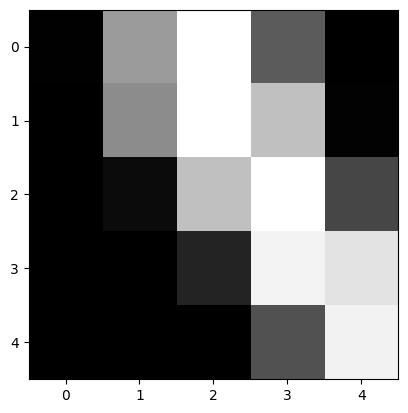

In [ ]:
# Plot the image by passing in the 28 * 28 matrix
plt.imshow(img_tensor[0,10:15, 10:15], cmap ='gray')

Note that we need to pass just the 28x28 matrix to `plt.imshow`, without a channel dimension. We also pass a color map (`cmap=gray`) to indicate that we want to see a grayscale image.

## Training and Validation Datasets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using gradient descent.
2. **Validation set** - used to evaluate the model during training, adjust hyperparameters (learning rate, etc.), and pick the best version of the model.
3. **Test set** - used to compare different models or approaches and report the model's final accuracy.

In the MNIST dataset, there are 60,000 training images and 10,000 test images. The test set is standardized so that different researchers can report their models' results against the same collection of images.
Since there's no predefined validation set, we must manually split the 60,000 images into training and validation datasets.

Let's set aside 10,000 randomly chosen images for validation. We can do this using the `random_spilt` method from PyTorch.

Let's define a function that randomly picks a given fraction of the images for the validation set.

In [ ]:
n = 60000
val_pct = 0.1
n_val = int(val_pct * n)
n_val

6000

In [ ]:
import numpy as np
def split_indices(n, val_pct):
  # Determine size of validation set
  n_val = int(val_pct * n)
  # Create random permutation of 0 to n-1
  idxs = np.random.permutation(n)
  # Pick first n_val indices for validation set
  return idxs[n_val:], idxs[:n_val]


`split_indices` randomly shuffles the array indices 0,1,..n-1, and separates out a desired portion from it for the validation set. It's important to shuffle the indices before creating a validation set, because the training images are often ordered by the target labels i.e. images of 0s, followed by images of 1s, followd by images of 2s and so on. If we were to pick a 20% validation set simply by selecting the last 20% of the images, the validation set would only consist of images of 8s and 9s , whereas the training set would contain no images of 8s and 9s. This would make it impossible to train a good model using the training set, which also performs well on the validation set(and on ideal world data)

In [ ]:
train_indices, val_indices = split_indices(len(dataset), val_pct = 0.2)

In [ ]:
print(len(train_indices), len(val_indices))
print('Sample val indices:', val_indices[:20])

48000 12000
Sample val indices: [16135 42850 26898 16512 22866 48303 21578 35800 54919 23235  2143 29985
  7546 57902 19512 27846   371  5743 24644 37426]


We have randomly shuffled the indices, and selected a small prtion (20%) to serve as the validation set. We can now create PyTorch dataloader for each of these using a `SubsetRandomSampler`, which samples elements randomly from a given list of indices, while greating batches of data.

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [ ]:
batch_size = 100
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size, sampler = train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler = val_sampler)

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`).

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model.

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [ ]:
import torch.nn as nn
input_size = 28 * 28
num_classes = 10

# Logistic regression model
model = nn.Linear(input_size, num_classes)

Of course, this model is a lot larger than our previous model, in terms of the number of parameters. Let's take a look at the weights and biases.

In [ ]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0157,  0.0236, -0.0021,  ...,  0.0117,  0.0293, -0.0356],
        [-0.0203,  0.0210, -0.0061,  ...,  0.0180, -0.0099, -0.0266],
        [ 0.0094, -0.0286,  0.0058,  ...,  0.0237,  0.0125, -0.0052],
        ...,
        [-0.0125,  0.0188, -0.0063,  ..., -0.0261,  0.0103,  0.0301],
        [-0.0116, -0.0262, -0.0008,  ..., -0.0096, -0.0146,  0.0265],
        [ 0.0211,  0.0073, -0.0138,  ...,  0.0297, -0.0074, -0.0090]],
       requires_grad=True)

In [ ]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([ 0.0153, -0.0236, -0.0301, -0.0337, -0.0252,  0.0203,  0.0045,  0.0252,
        -0.0028, -0.0135], requires_grad=True)

Although there are a total of 7850 parameters here, conceptually, nothing has changed so far. Let's try and generate some outputs using our model. We'll take the first batch of 100 images from our dataset and pass them into our model.

In [ ]:
for images, labels in train_loader:
  print(labels)
  print(images.shape)
  outputs = model(images)
  break

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch.

A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

In [ ]:
class MnistModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

model = MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 28\*28 (i.e., 784). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [ ]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0182,  0.0291, -0.0202,  ..., -0.0118,  0.0248, -0.0088],
         [-0.0118, -0.0116,  0.0112,  ..., -0.0281, -0.0219, -0.0143],
         [ 0.0123,  0.0257,  0.0208,  ...,  0.0341,  0.0174,  0.0160],
         ...,
         [ 0.0149,  0.0191,  0.0335,  ...,  0.0137, -0.0116,  0.0161],
         [ 0.0039, -0.0126,  0.0090,  ...,  0.0211,  0.0135,  0.0243],
         [ 0.0314, -0.0334, -0.0188,  ..., -0.0013,  0.0244, -0.0135]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0331,  0.0295, -0.0338,  0.0152, -0.0068, -0.0092, -0.0051, -0.0189,
          0.0314, -0.0072], requires_grad=True)]

We can use our new custom model in the same way as before. Let's see if it works.

In [ ]:
for images, labels in train_loader:
  outputs = model(images)
  break
print('outputs.shape :', outputs.shape)
print('Sample outputs : \n', outputs[:2].data)

outputs.shape : torch.Size([100, 10])
Sample outputs : 
 tensor([[ 0.3144, -0.2402, -0.1138,  0.2106,  0.1908, -0.0617, -0.2749, -0.0511,
         -0.1807,  0.3871],
        [ 0.6165, -0.0380,  0.0218,  0.1577,  0.1408, -0.3205, -0.1133, -0.1258,
         -0.0272,  0.4870]])


For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case.

To convert the output rows into probabilities, we use the softmax function, which has the following formula:

![softmax](https://i.imgur.com/EAh9jLN.png)

First, we replace each element `yi` in an output row by `e^yi`, making all the elements positive.

![](https://www.montereyinstitute.org/courses/DevelopmentalMath/COURSE_TEXT2_RESOURCE/U18_L1_T1_text_final_6_files/image001.png)



Then, we divide them by their sum to ensure that they add up to 1. The resulting vector can thus be interpreted as probabilities.

While it's easy to implement the softmax function (you should try it!), we'll use the implementation that's provided within PyTorch because it works well with multidimensional tensors (a list of output rows in our case).

In [ ]:
import torch.nn.functional as F

The softmax function is included in the `torch.nn.functional` package and requires us to specify a dimension along which the function should be applied.

In [ ]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim = 1)

#Look at sample probabilities
print('Sample probabilities:\n', probs[:2].data)

#Add up the probabilities of an output row
print('Sum: ', torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1310, 0.0753, 0.0854, 0.1181, 0.1158, 0.0900, 0.0727, 0.0909, 0.0799,
         0.1409],
        [0.1645, 0.0855, 0.0908, 0.1040, 0.1022, 0.0645, 0.0793, 0.0783, 0.0864,
         0.1445]])
Sum:  1.0


Finally, we can determine the predicted label for each image by simply choosing the index of the element with the highest probability in each output row. We can do this using `torch.max`, which returns each row's largest element and the corresponding index.

In [ ]:
max_probs, preds = torch.max(probs, dim = 1)
print(preds)
#print(max_probs)

tensor([9, 0, 9, 3, 3, 2, 9, 3, 9, 0, 9, 3, 9, 9, 9, 1, 9, 9, 3, 3, 7, 3, 3, 0,
        9, 9, 5, 0, 0, 3, 9, 3, 0, 1, 0, 9, 0, 9, 9, 3, 9, 1, 9, 6, 9, 1, 0, 9,
        9, 3, 0, 0, 0, 0, 9, 9, 9, 3, 9, 3, 3, 8, 9, 0, 0, 3, 9, 3, 3, 0, 7, 3,
        9, 7, 9, 9, 9, 0, 0, 0, 7, 3, 3, 9, 9, 8, 0, 3, 9, 1, 4, 3, 3, 9, 2, 3,
        9, 7, 0, 1])


The numbers printed above are the predicted labels for the first batch of training images. Let's compare them with the actual labels.

In [ ]:
labels

tensor([9, 7, 8, 5, 1, 6, 7, 4, 0, 7, 9, 4, 2, 1, 7, 1, 5, 3, 3, 6, 0, 8, 7, 9,
        2, 2, 9, 9, 3, 0, 4, 4, 3, 3, 9, 6, 7, 7, 8, 9, 1, 1, 4, 4, 9, 5, 3, 4,
        1, 3, 8, 7, 9, 9, 1, 0, 0, 8, 1, 8, 2, 0, 2, 9, 8, 8, 9, 2, 2, 4, 3, 3,
        3, 0, 2, 4, 0, 8, 9, 3, 4, 4, 6, 4, 4, 2, 7, 4, 5, 2, 4, 4, 4, 1, 0, 9,
        6, 2, 5, 8])

Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

## Evaluation Metric and Loss Function
Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the **accuracy** of the predictions.

In [ ]:
torch.sum(labels == preds).item() / len(labels)

0.1

In [ ]:
def accuracy(l1, l2):
  return torch.sum(l1 == l2).item() / len(labels)

The `==` operator performs an element-wise comparison of two tensors with the same shape and returns a tensor of the same shape, containing `0s` for unequal elements and `1s` for equal elements. Passing the result to `torch.sum` returns the number of labels that were predicted correctly. Finally, we divide by the total number of images to get the accuracy.

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because `e^x` is an increasing function, i.e., if `y1 > y2`, then `e^y1 > e^y2`. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data.

In [ ]:
accuracy(preds, labels)

0.1

While the accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements.

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [ ]:
loss_fn = F.cross_entropy

In [ ]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2936, grad_fn=<NllLossBackward0>)


We know that cross-entropy is the negative logarithm of the predicted probability of the correct label averaged over all training samples. Therefore, one way to interpret the resulting number e.g. `2.23` is look at `e^-2.23` which is around `0.1` as the predicted probability of the correct label, on average. *The lower the loss, The better the model.*

# Optimizer

We are going to use the `optim.SGD` optimizer to update the weights and biases during training, but with a higher learning rate of `le-3`

In [ ]:
Learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = Learning_rate)

Parameters like batch size, learning rate etc. need to be picked in advance while training machine learning models, and are called hyperparameters. Picking the right hyperparameters is critical for training an accurate model within a reasonable amount of time, and is an active area of research and experimentation. Feel free to try different learning rates and see how it affects the training process.

## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression. However, we'll augment the `fit` function we defined earlier to evaluate the model's accuracy and loss using the validation set at the end of every epoch.

We begin by defining the loss function `loss_batch` which:

with the addition of a "validation phase" to evaluate the model in each epoch.

  *   Calcuate the loss for a batch of data
  *   Optionally perform the gradient descent update step if an optimizer is provided
  *   Optionally computes a metric (e.g. accuracy) using the predictioms and actual targets




Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem.

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.


In [ ]:
def loss_batch(model, loss_func, xb, yb, opt = None, metric = None):
  # calculate loss
  preds = model(xb)
  loss = loss_func(preds, yb)

  if opt is not None:
    # Compute gradients
    loss.backward()
    # Update parameters
    opt.step()
    # Reset gradients
    opt.zero_grad()
  metric_result = None
  if metric is not None:
    # Compute the metric
    metric_result = metric(preds, yb)
  return loss.item(), len(xb), metric_result

The optimizer is an optional argument, to ensure that we can reuse `loss_batch` for computing the loss on the validation set. We also retur the ength of the batch as part of the result, as it'll be useful while compbining the losses/metrices for the entire dataset.

Next we define an evaluation function , which calcualtes the overall loss(and a metric, if provided) for the validation set.

In [ ]:
def evaluate(model, loss_fn, valid_dl, metric = None):
  with torch.no_grad():
  # For the validation set, we donot need to compute the gradients atall,
  #because gradients are required for gradient descent algorithm which we will only do with training data.
  #Validation set is only for reporting purposes, so that we can evaluate out model.
    # Pass each batch through the model

    results = [loss_batch(model, loss_fn, xb, yb, metric = metric) for xb, yb in valid_dl]# list comprehension

    # Seperate losses, counts and metrices
    losses, nums, metrics = zip(*results)

    # Total size of the dataset
    total = np.sum(nums)# The length of each batch might not be equal as number of training data might not be perfectly divisible in batches.
    #So, the loss is computed exactly by averaging the number of elements.

    # Avg. loss across batches
    avg_loss = np.sum(np.multiply(losses, nums)) / total
    avg_metric = None
    if metric is not None:
      # Avg. of metric across batches
      avg_metric = np.sum(np.multiply(metrics, nums)) / total
    return avg_loss, total , avg_metric

If it's not immediately clear what this funciton deos, try executing each statement in a seperate cell, and look at the results. We also need to redefine the `accuracy` to operate on an entire batch of outputs directly, so that we can use it as metric in `fit`.

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim = 1)
  return torch.sum(preds == labels).item() / len(preds)

Note that we don't need to apply softmax to the outputs since its results have the same relative order. This is because `e^x` is an increasing function, i.e., if `y1 > y2`, then `e^y1 > e^y2`. The same holds after averaging out the values to get the softmax.

Let's calculate the accuracy of the current model on the first batch of data.

In [ ]:
val_loss, total, val_acc = evaluate(model, loss_fn, val_loader, metric = accuracy)
print('Loss: {: .4f}, Accuracy: {: .4f}'.format(val_loss, val_acc))

Loss:  2.3118, Accuracy:  0.1371


The initial accuracy is below 10%, which is what one might expect from a randomly initialized model(since it has 1 in 10 chance of getting a label right by guessing randomly). Also note that we are using the `.format` method with the message string to print only the first four digits after the decimal point.

We can now define the `fit` function quite easily using `loss_batch` and `evaluate`.

In [ ]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric = None):
  for epoch in range(epochs):
    # Training
    for xb, yb in train_dl:
      loss,_,_ = loss_batch(model, loss_fn, xb, yb, opt)

      # Evaluation
      result = evaluate(model, loss_fn, valid_dl, metric)
      val_loss, total, val_metric = result

      # Print progress
      if metric is None:
        print('Epoch [{} / {}], Loss: {: .4f}'.format(epoch+1, epochs, val_loss))
      else:
        print('Epoch [{} / {}], Loss: {: .4f}, {}: {:.4f}'.format(epoch+1, epochs, val_loss, metric.__name__, val_metric))


We are now ready to train the model. Let's train for 5 epochs and look at the results.


In [ ]:
# Redefine the model and the optimizer
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr = Learning_rate)

In [ ]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1 / 5], Loss:  2.3288, accuracy: 0.1405
Epoch [1 / 5], Loss:  2.3276, accuracy: 0.1407
Epoch [1 / 5], Loss:  2.3264, accuracy: 0.1415
Epoch [1 / 5], Loss:  2.3252, accuracy: 0.1425
Epoch [1 / 5], Loss:  2.3240, accuracy: 0.1432
Epoch [1 / 5], Loss:  2.3225, accuracy: 0.1442
Epoch [1 / 5], Loss:  2.3212, accuracy: 0.1451
Epoch [1 / 5], Loss:  2.3199, accuracy: 0.1459
Epoch [1 / 5], Loss:  2.3188, accuracy: 0.1468
Epoch [1 / 5], Loss:  2.3176, accuracy: 0.1473
Epoch [1 / 5], Loss:  2.3163, accuracy: 0.1489
Epoch [1 / 5], Loss:  2.3150, accuracy: 0.1499
Epoch [1 / 5], Loss:  2.3138, accuracy: 0.1504
Epoch [1 / 5], Loss:  2.3127, accuracy: 0.1514
Epoch [1 / 5], Loss:  2.3115, accuracy: 0.1529
Epoch [1 / 5], Loss:  2.3102, accuracy: 0.1536
Epoch [1 / 5], Loss:  2.3090, accuracy: 0.1539
Epoch [1 / 5], Loss:  2.3078, accuracy: 0.1547
Epoch [1 / 5], Loss:  2.3066, accuracy: 0.1557
Epoch [1 / 5], Loss:  2.3055, accuracy: 0.1562
Epoch [1 / 5], Loss:  2.3043, accuracy: 0.1570
Epoch [1 / 5]

That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set. Let's see of we can improve that by training for few more epochs.

In [ ]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

In [ ]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

In [ ]:
fit(5, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

While the accuracy does not continue to increase as we train for more epochs, the improvements get smaller with every epoch. This is easier to see using a line graph.

In [ ]:
# Replace these values with your results
accuracies = []
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')

It's quite clear from the above picture that the model probably won't cross the accuracy threshold of 90% even after training for a very long time. One possible reason for this is that
.  

*   the learning rate might be too high
*   The model's parameters may be "bouncing" around the optimal set of parameters for the lowest loss

*   You can try reducing the learning rate and training for a few more epochs to see if it helps.

*   The more likely reason that **the model just isn't powerful enough**.

If you remember our initial hypothesis,  

*   we have assumed that the output (in this case the class probabilities) is a **linear function** of the input (pixel intensities), obtained by perfoming a matrix multiplication with the weights matrix and adding the bias.
*   This is a fairly weak assumption, as there may not actually exist a linear relationship between the pixel intensities in an image and the digit it represents.

 While it works reasonably well for a simple dataset like MNIST (getting us to 85% accuracy), we need more sophisticated models that can capture non-linear relationships between image pixels and labels for complex tasks like recognizing everyday objects, animals etc.